# Mutation analysis, COSMIC lookup

Works with the following columns:
- DISEASE
- WGS_DISEASE
- CLINVAR_CLNSIG, CLINVAR_TRAIT
- MUTATION_SIGNIFICANCE_TIER
- CGC_TIER
- ONC_TSG

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [2]:
import os
import subprocess
from collections import OrderedDict
import shutil
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
import gget
import varseek as vk
from varseek.utils import convert_mutation_cds_locations_to_cdna

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

### File path definitions and imports

In [ ]:
n = 200

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")

out_dir = os.path.join(vk_count_out_dir, "analysis", "cosmic_lookup")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
cosmic_tsv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37.tsv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")

os.makedirs(out_dir, exist_ok=True)

In [ ]:
# download cosmic and cdna
if not os.path.exists(sequences_cdna):
    print("Downloading cDNA")
    reference_cdna_dir = os.path.dirname(sequences_cdna) if os.path.dirname(sequences_cdna) else "."
    gget_ref_command = ["gget", "ref", "-w", "cdna", "-r", "93", "--out_dir", reference_cdna_dir, "-d", "human_grch37"]
    subprocess.run(gget_ref_command, check=True)
    subprocess.run(["gunzip", f"{sequences_cdna}.gz"], check=True)
if not os.path.exists(sequences_cds):
    print("Downloading CDS")
    reference_cds_dir = os.path.dirname(sequences_cds) if os.path.dirname(sequences_cds) else "."
    gget_ref_command = ["gget", "ref", "-w", "cds", "-r", "93", "--out_dir", reference_cds_dir, "-d", "human_grch37"]
    subprocess.run(gget_ref_command, check=True)
    subprocess.run(["gunzip", f"{sequences_cds}.gz"], check=True)

if not os.path.exists(cosmic_csv) or not os.path.exists(cosmic_tsv):
    print("Downloading COSMIC")
    reference_out_dir_cosmic = os.path.dirname(os.path.dirname(cosmic_csv))
    gget.cosmic(
        None,
        grch_version=37,
        cosmic_version=101,
        out=reference_out_dir_cosmic,
        cosmic_project="cancer",
        download_cosmic=True,
        gget_mutate=True,
    )

cosmic_df = pd.read_csv(cosmic_csv, nrows=2)

if "mutation_cdna" not in cosmic_df.columns:
    print("Converting CDS to cDNA in COSMIC")
    _, _ = convert_mutation_cds_locations_to_cdna(input_csv_path=cosmic_csv, output_csv_path=cosmic_csv, cds_fasta_path=sequences_cds, cdna_fasta_path=sequences_cdna, verbose=True, strip_leading_Ns_cds=True)

cosmic_df = pd.read_csv(cosmic_csv)
if "vcrs_header_cdna" not in cosmic_df.columns:
    cosmic_df["vcrs_header_cdna"] = cosmic_df["seq_ID"] + ":" + cosmic_df["mutation_cdna"]
if "vcrs_header_cds" not in cosmic_df.columns:
    cosmic_df["vcrs_header_cds"] = cosmic_df["seq_ID"] + ":" + cosmic_df["mutation"]
    # cosmic_df.to_csv(cosmic_csv, index=False)

/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_56393/1136658275.py:34: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_df = pd.read_csv(cosmic_csv)


In [5]:
cosmic_df.head()

,seq_ID,mutation,mutation_aa,GENOMIC_MUTATION_ID,chromosome,strand,mutation_genome,gene_name,mutation_id,mutation_cdna,header,vcrs_header_cdna,vcrs_header_cds
0,ENST00000396153,c.1468C>T,p.Q490*,COSV105286190,1,-,g.51001067G>A,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T,ENST00000396153:c.1920C>T,ENST00000396153:c.1468C>T
1,ENST00000445907,c.162C>A,p.L54=,COSV57765075,7,+,g.136699774C>A,CHRM2,60222372,c.690C>A,ENST00000445907:c.690C>A,ENST00000445907:c.690C>A,ENST00000445907:c.162C>A
2,ENST00000445907,c.617A>T,p.Y206F,COSV108138517,7,+,g.136700229A>T,CHRM2,60229878,c.1145A>T,ENST00000445907:c.1145A>T,ENST00000445907:c.1145A>T,ENST00000445907:c.617A>T
3,ENST00000445907,c.93A>T,p.G31=,COSV100282253,7,+,g.136699705A>T,CHRM2,60227007,c.621A>T,ENST00000445907:c.621A>T,ENST00000445907:c.621A>T,ENST00000445907:c.93A>T
4,ENST00000445907,c.956A>C,p.N319T,COSV108138508,7,+,g.136700568A>C,CHRM2,60213402,c.1484A>C,ENST00000445907:c.1484A>C,ENST00000445907:c.1484A>C,ENST00000445907:c.956A>C


In [6]:
cosmic_df_full = pd.read_csv(cosmic_tsv, sep="\t")
cosmic_df_full["mutation_id"] = cosmic_df_full["MUTATION_URL"].str.extract(r"id=(\d+)").astype("int64")
cosmic_df_full.head()

/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_56393/1935688988.py:1: DtypeWarning: Columns (2,56) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_df_full = pd.read_csv(cosmic_tsv, sep="\t")


,GENE_NAME,ACCESSION_NUMBER,ONC_TSG,CGC_TIER,MUTATION_URL,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,AA_MUT_START,AA_MUT_STOP,SHARED_AA,GENOMIC_WT_ALLELE_SEQ,GENOMIC_MUT_ALLELE_SEQ,AA_WT_ALLELE_SEQ,AA_MUT_ALLELE_SEQ,Mutation Description CDS,Mutation Description AA,ONTOLOGY_MUTATION_CODE,GENOMIC_MUTATION_ID,Mutation genome position GRCh37,Mutation genome position GRCh38,COSMIC_SAMPLE_TESTED,COSMIC_SAMPLE_MUTATED,DISEASE,WGS_DISEASE,EXAC_AF,EXAC_AFR_AF,EXAC_AMR_AF,EXAC_ADJ_AF,EXAC_EAS_AF,EXAC_FIN_AF,EXAC_NFE_AF,EXAC_SAS_AF,GNOMAD_EXOMES_AF,GNOMAD_EXOMES_AFR_AF,GNOMAD_EXOMES_AMR_AF,GNOMAD_EXOMES_ASJ_AF,GNOMAD_EXOMES_EAS_AF,GNOMAD_EXOMES_FIN_AF,GNOMAD_EXOMES_NFE_AF,GNOMAD_EXOMES_SAS_AF,GNOMAD_GENOMES_AF,GNOMAD_GENOMES_AFR_AF,GNOMAD_GENOMES_AMI_AF,GNOMAD_GENOMES_AMR_AF,GNOMAD_GENOMES_ASJ_AF,GNOMAD_GENOMES_EAS_AF,GNOMAD_GENOMES_FIN_AF,GNOMAD_GENOMES_MID_AF,GNOMAD_GENOMES_NFE_AF,GNOMAD_GENOMES_SAS_AF,CLINVAR_CLNSIG,CLINVAR_TRAIT,GERP++_RS,MIN_SIFT_SCORE,MIN_SIFT_PRED,DNDS_DISEASE_QVAL_SIG,MUTATION_SIGNIFICANCE_TIER,mutation_id
0,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM9691637,c.1468C>T,p.Q490*,490,490,1,G,A,Q,*,Substitution,Substitution - Nonsense,SO:0001587,COSV105286190,1:51001067-51001067,1:50535395-50535395,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.52,1.000,NaN,NaN,Other,48293736
1,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM7986191,c.711G>T,p.W237C,237,237,1,C,A,W,C,Substitution,Substitution - Missense,SO:0001583,COSV100875125,1:51121147-51121147,1:50655475-50655475,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.17,0.000,D,NaN,Other,48304295
2,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM6063740,c.1548C>T,p.R516=,516,516,2,G,A,R,R,Substitution,Substitution - coding silent,SO:1000057,COSV65638235,1:50957420-50957420,1:50491748-50491748,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other,48302907
3,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM6657959,c.429del,p.G144Afs*13,144,144,1,T,NaN,G,AGRREMWKTVRS*,Deletion,Deletion - Frameshift,SO:0001589,COSV65641246,1:51210389-51210389,1:50744717-50744717,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other,48291600
4,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM10419714,c.797G>A,p.G266E,266,266,1,C,T,G,E,Substitution,Substitution - Missense,SO:0001583,COSV107478819,1:51061836-51061836,1:50596164-50596164,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.64,0.248,T,NaN,Other,48301048


### Load in adata.var and merge in cosmic data

In [7]:
adata = ad.read_h5ad(adata_path)

adata.var.rename(columns={"vcrs_header": "vcrs_header_cdna"}, inplace=True)
if "vcrs_id" not in adata.var.columns:
    adata.var["vcrs_id"] = adata.var["vcrs_header_cdna"]
variant_id_column = "vcrs_header_with_gene_name" if "vcrs_header_with_gene_name" in adata.var.columns else "vcrs_id"

adata = adata[:, adata.var[~adata.var['vcrs_header_cdna'].str.contains(';', na=False)].index].copy()  # For simplicity, filter out all mutants with ambiguous identity
# adata.var["variant_id_first"] = adata.var[variant_id_column].str.split(";").str[0]  # as an alternative to the above - take the first variant header of the merged variant headers (they're often splice isoforms anyways)
# variant_id_column = "variant_id_first"

# keep only the top n variants
top_vcrs = adata.var["vcrs_count"].nlargest(n).index
adata = adata[:, top_vcrs].copy()
adata.var = adata.var.merge(cosmic_df[["vcrs_header_cdna", "mutation_id"]], on="vcrs_header_cdna", how="left", suffixes=("_original", ""))
adata.var = adata.var.merge(cosmic_df_full, on="mutation_id", how="left", suffixes=("_original", ""))

adata.var.head()

,vcrs_header_cdna,vcrs_count,gene_name,vcrs_id,mutation_id,GENE_NAME,ACCESSION_NUMBER,ONC_TSG,CGC_TIER,MUTATION_URL,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,AA_MUT_START,AA_MUT_STOP,SHARED_AA,GENOMIC_WT_ALLELE_SEQ,GENOMIC_MUT_ALLELE_SEQ,AA_WT_ALLELE_SEQ,AA_MUT_ALLELE_SEQ,Mutation Description CDS,Mutation Description AA,ONTOLOGY_MUTATION_CODE,GENOMIC_MUTATION_ID,Mutation genome position GRCh37,Mutation genome position GRCh38,COSMIC_SAMPLE_TESTED,COSMIC_SAMPLE_MUTATED,DISEASE,WGS_DISEASE,EXAC_AF,EXAC_AFR_AF,EXAC_AMR_AF,EXAC_ADJ_AF,EXAC_EAS_AF,EXAC_FIN_AF,EXAC_NFE_AF,EXAC_SAS_AF,GNOMAD_EXOMES_AF,GNOMAD_EXOMES_AFR_AF,GNOMAD_EXOMES_AMR_AF,GNOMAD_EXOMES_ASJ_AF,GNOMAD_EXOMES_EAS_AF,GNOMAD_EXOMES_FIN_AF,GNOMAD_EXOMES_NFE_AF,GNOMAD_EXOMES_SAS_AF,GNOMAD_GENOMES_AF,GNOMAD_GENOMES_AFR_AF,GNOMAD_GENOMES_AMI_AF,GNOMAD_GENOMES_AMR_AF,GNOMAD_GENOMES_ASJ_AF,GNOMAD_GENOMES_EAS_AF,GNOMAD_GENOMES_FIN_AF,GNOMAD_GENOMES_MID_AF,GNOMAD_GENOMES_NFE_AF,GNOMAD_GENOMES_SAS_AF,CLINVAR_CLNSIG,CLINVAR_TRAIT,GERP++_RS,MIN_SIFT_SCORE,MIN_SIFT_PRED,DNDS_DISEASE_QVAL_SIG,MUTATION_SIGNIFICANCE_TIER
0,ENST00000362079:c.760G>A,10166.0,MT-CO3,ENST00000362079:c.760G>A,38849708,MT-CO3,ENST00000362079.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM7419924,c.760G>A,p.V254I,254,254,2,G,A,V,I,Substitution,Substitution - Missense,SO:0001583,COSV100677712,MT:9966-9966,MT:9966-9966,49031,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.88,1.000,NaN,NaN,Other
1,ENST00000393099:c.583G>A,7259.0,RPL13,ENST00000393099:c.583G>A,45207829,RPL13,ENST00000393099.3,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM7337848,c.334G>A,p.A112T,112,112,1,G,A,A,T,Substitution,Substitution - Missense,SO:0001583,COSV51948976,16:89628073-89628073,16:89561665-89561665,49774,3,NaN,NaN,0.1614,0.0405,0.1109,0.1624,0.001,0.1705,0.2251,0.1038,0.163,0.0372,0.1265,0.2099,0.0008,0.1728,0.2265,0.1013,0.1541,0.0405,0.2072,0.1903,0.1928,0.0015,0.1711,0.3291,0.2233,0.0911,NaN,NaN,4.29,0.236,T,NaN,Other
2,ENST00000251453:c.455C>T,5370.0,RPS16,ENST00000251453:c.455C>T,21768702,RPS16,ENST00000251453.3,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3756781,c.402C>T,p.G134=,134,134,1,G,A,G,G,Substitution,Substitution - coding silent,SO:1000057,COSV52238593,19:39923952-39923952,19:39433312-39433312,49031,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other
3,ENST00000423316:c.2076C>T,4317.0,EEF1D,ENST00000423316:c.2076C>T,53611998,EEF1D,ENST00000423316.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM5619450,c.1734C>T,p.A578=,578,578,2,G,A,A,A,Substitution,Substitution - coding silent,SO:1000057,COSV52782639,8:144662353-144662353,8:143580183-143580183,49031,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other
4,ENST00000593646:c.53G>A,2736.0,AC040977.1,ENST00000593646:c.53G>A,98788192,AC040977.1,ENST00000593646.1,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM4130538,c.53G>A,p.R18H,18,18,1,C,T,R,H,Substitution,Substitution - Missense,SO:0001583,COSV52351111,17:6917703-6917703,17:7014384-7014384,49031,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other


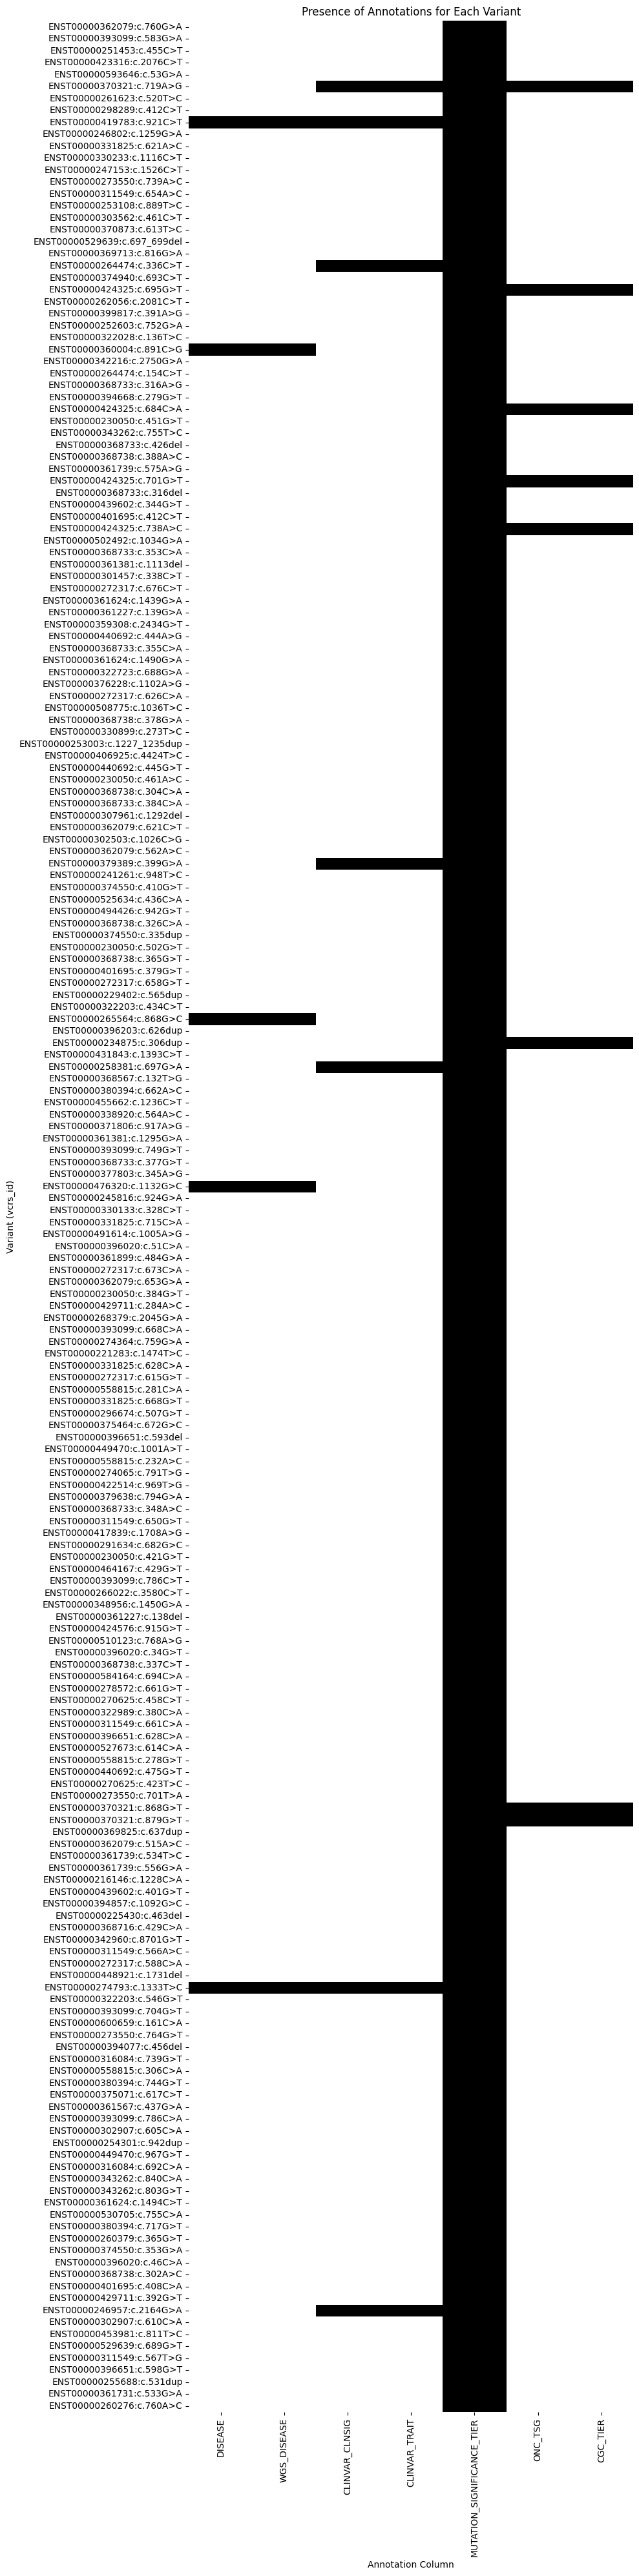

In [10]:
# Columns to check
cols_to_check = [
    "DISEASE", "WGS_DISEASE", "CLINVAR_CLNSIG", "CLINVAR_TRAIT",
    "MUTATION_SIGNIFICANCE_TIER", "ONC_TSG", "CGC_TIER"
]

# Create binary matrix: 1 if value is not null/empty, 0 otherwise
notna_mask = adata.var[cols_to_check].notna()
not_empty_mask = adata.var[cols_to_check].applymap(str).applymap(str.strip).ne("")
presence_matrix = (notna_mask & not_empty_mask).astype(int)
presence_matrix[variant_id_column] = adata.var[variant_id_column]
presence_matrix.set_index(variant_id_column, inplace=True)

plt.figure(figsize=(10, max(6, 0.2 * len(presence_matrix))))
sns.heatmap(presence_matrix, cmap="Greys", cbar=False)
plt.xlabel("Annotation Column")
plt.ylabel(f"Variant ({variant_id_column})")
plt.title("Presence of Annotations for Each Variant")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "cosmic_annotations_heatmap.pdf"), bbox_inches="tight")
plt.show()

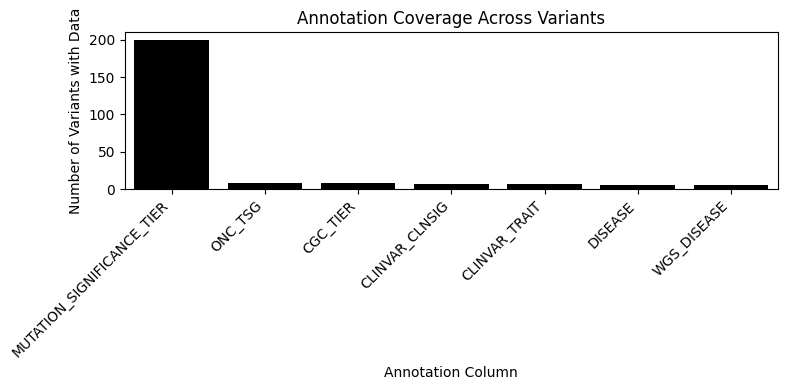

In [11]:
# Sum over rows to get count of non-empty entries per column
annotation_counts = presence_matrix.sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, color="black")
plt.ylabel("Number of Variants with Data")
plt.xlabel("Annotation Column")
plt.title("Annotation Coverage Across Variants")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "cosmic_annotations_histogram.pdf"), bbox_inches="tight")
plt.show()


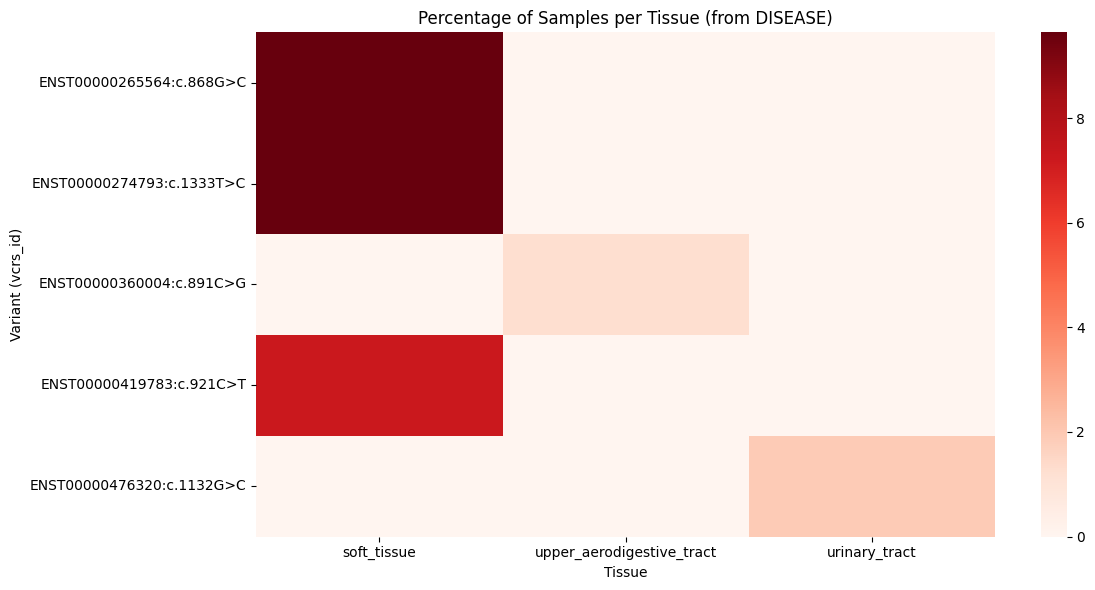

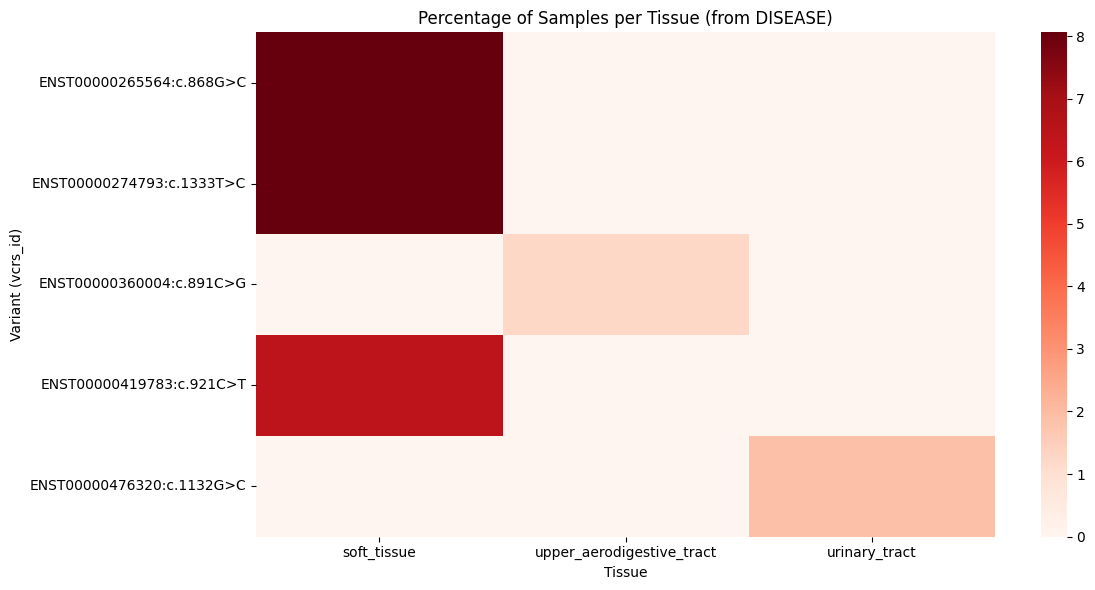

In [19]:
def plot_disease(df, variant_id_column="vcrs_id", disease_col="DISEASE", heatmap_col="tissue"):
    """
    Assumes df has columns variant_id_column and "DISEASE"
    heatmap_col {"tissue", "primary_histology", "sub_histology"}
    """
    df = df.copy()
    
    # Step 1: Split and explode by semicolon
    df[disease_col] = df[disease_col].astype(str).str.strip()
    df["DISEASE_individual"] = df[disease_col].str.split(";")
    df = df[[variant_id_column, "DISEASE_individual"]].explode("DISEASE_individual").dropna()

    # Step 2: Split by equal sign
    df["DISEASE_individual"] = df["DISEASE_individual"].astype(str).where(df["DISEASE_individual"].notna(), None)
    split_cols = df["DISEASE_individual"].str.split("=", expand=True)
    split_cols.columns = ["tissue_group", "fraction_samples", "percentage_samples"]
    df = df.join(split_cols)

    # Step 3: Clean and convert percentage_samples to float
    df["percentage_samples"] = pd.to_numeric(df["percentage_samples"].astype(str).str.rstrip('%'), errors="coerce")
    df = df.dropna(subset=["percentage_samples"])

    # Step 3.5: Split by slash
    df[["tissue", "primary_histology", "sub_histology"]] = df["tissue_group"].str.split("/", expand=True)

    # Step 4: Pivot to wide format
    heatmap_df = df.pivot_table(index=variant_id_column, columns=heatmap_col, values="percentage_samples", aggfunc="max").fillna(0)

    # Step 5: Plot heatmap
    plt.figure(figsize=(12, max(6, 0.2 * len(heatmap_df))))
    sns.heatmap(heatmap_df, cmap="Reds")
    plt.title("Percentage of Samples per Tissue (from DISEASE)")
    plt.xlabel("Tissue")
    plt.ylabel("Variant (vcrs_id)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cosmic_{disease_col}_heatmap_{heatmap_col}.pdf"), bbox_inches="tight")
    plt.show()


plot_disease(adata.var, disease_col="DISEASE", heatmap_col="tissue", variant_id_column=variant_id_column)
plot_disease(adata.var, disease_col="WGS_DISEASE", heatmap_col="tissue", variant_id_column=variant_id_column)

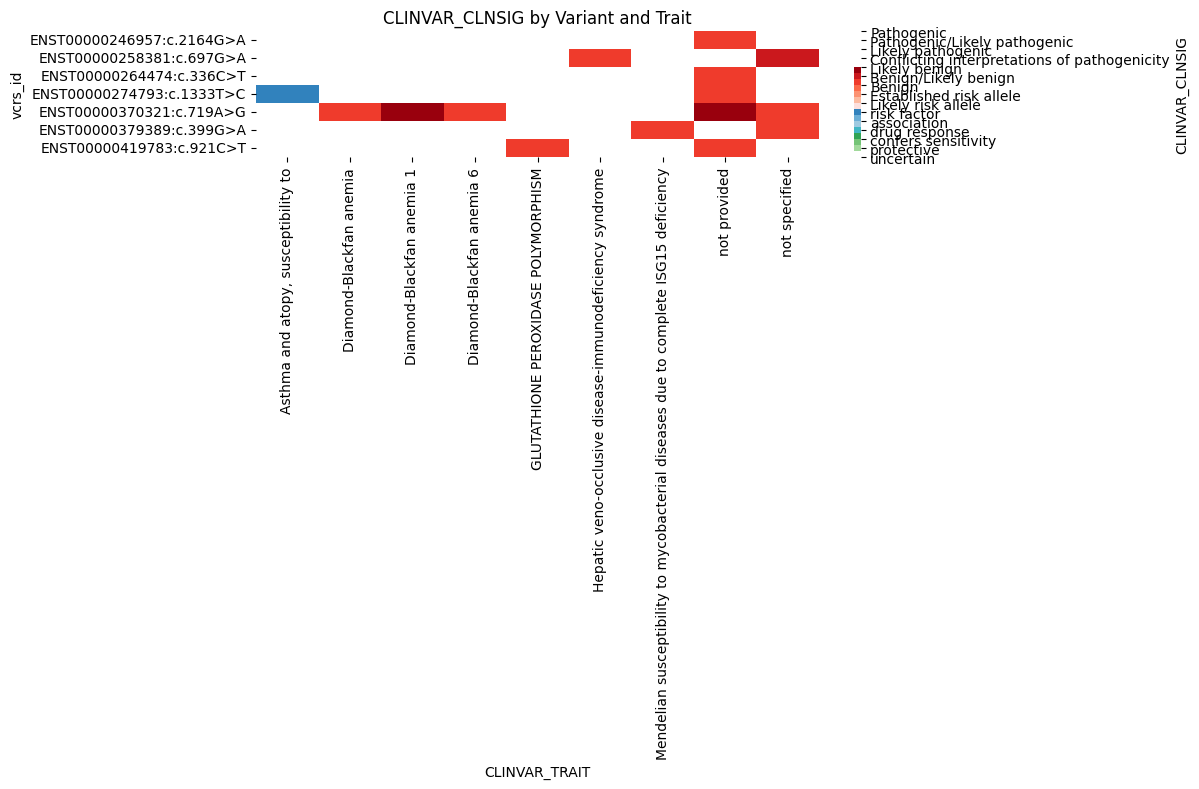

In [13]:
# cosmic_df_full_tmp = cosmic_df_full[["CLINVAR_CLNSIG"]].dropna().copy()
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split("&")
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# CLINVAR_CLNSIG_unique_values = sorted(cosmic_df_full_tmp['CLINVAR_CLNSIG'].unique().tolist())
# print(len(CLINVAR_CLNSIG_unique_values))
# print(CLINVAR_CLNSIG_unique_values)

# Step 0: Ordered mapping
CLINVAR_CLNSIG_mapping = OrderedDict([
    ('not provided', 'uncertain'),  # anything ambiguous will be uncertain
    ('other', 'uncertain'),
    ('Uncertain significance', 'uncertain'),
    ('Uncertain risk allele', 'uncertain'),
    ('protective', 'protective'),
    ('confers sensitivity', 'confers sensitivity'),
    ('drug response', 'drug response'),
    ('Affects', 'association'),
    ('association', 'association'),
    ('risk factor', 'risk factor'),
    ('Likely risk allele', 'Likely risk allele'),
    ('Established risk allele', 'Established risk allele'),
    ('Benign', 'Benign'),
    ('Benign/Likely benign', 'Benign/Likely benign'),
    ('Likely benign', 'Likely benign'),
    ('Conflicting interpretations of pathogenicity', 'Conflicting interpretations of pathogenicity'),   #!!! change some labels, and add to color mapping below
    ('Likely pathogenic', 'Likely pathogenic'),
    ('Pathogenic/Likely pathogenic', 'Pathogenic/Likely pathogenic'),
    ('Pathogenic', 'Pathogenic'),
])

category_order = list(OrderedDict.fromkeys(CLINVAR_CLNSIG_mapping.values()))  # preserves order
category_colors = {
    'uncertain': '#ffffff',
    
    # Shades of green
    'protective': '#a1d99b',
    'confers sensitivity': '#74c476',
    'drug response': '#31a354',

    # Shades of blue
    'risk factor': '#9ecae1',
    'Likely risk allele': '#6baed6',
    'Established risk allele': '#3182bd',
    'association': '#41b6c4',

    # Shades of red
    'Benign': '#fde0dd',                      # light pink
    'Benign/Likely benign': '#fcbba1',        # peach
    'Likely benign': '#fc9272',               # coral
    'Conflicting interpretations of pathogenicity': '#fb6a4a',  # red-orange
    'Likely pathogenic': '#ef3b2c',           # red
    'Pathogenic/Likely pathogenic': '#cb181d',# deep red
    'Pathogenic': '#99000d',                  # darkest red
}

def plot_clinvar(df, variant_id_column="vcrs_id"):
    # Step 1: Subset and drop NA
    df = df[[variant_id_column, "CLINVAR_CLNSIG", "CLINVAR_TRAIT"]].dropna().copy()

    # Step 2: Split both columns on "&"
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split("&")
    df["CLINVAR_TRAIT"] = df["CLINVAR_TRAIT"].astype(str).str.split("&")

    # Step 3: Explode both
    df = df.explode(["CLINVAR_CLNSIG", "CLINVAR_TRAIT"], ignore_index=True)

    # 3.5. Explode CLINVAR_CLNSIG by semicolon
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
    df = df.explode(["CLINVAR_CLNSIG"], ignore_index=True)
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].map(CLINVAR_CLNSIG_mapping).fillna("uncertain")

    # Pivot table (with aggregation in case of duplicates)
    pivot_df = df.pivot_table(
        index=variant_id_column,
        columns='CLINVAR_TRAIT',
        values='CLINVAR_CLNSIG',
        aggfunc='first'  # or join as needed
    )

    # Map categories to integers in custom order
    category_to_code = {cat: i for i, cat in enumerate(category_order)}
    code_matrix = pivot_df.applymap(lambda x: category_to_code.get(x, -1))
    mask = code_matrix == -1

    # Build colormap
    color_list = [category_colors[c] for c in category_order]
    cmap = ListedColormap(color_list)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        code_matrix,
        cmap=cmap,
        mask=mask,
        cbar_kws={'ticks': range(len(category_order)), 'label': 'CLINVAR_CLNSIG'}
    )

    # Set ordered tick labels
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticks(range(len(category_order)))
    cbar.set_ticklabels(category_order)

    plt.title('CLINVAR_CLNSIG by Variant and Trait')
    plt.xlabel('CLINVAR_TRAIT')
    plt.ylabel(variant_id_column)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "cosmic_clinvar_heatmap.pdf"), bbox_inches="tight")
    plt.show()

plot_clinvar(adata.var, variant_id_column=variant_id_column)

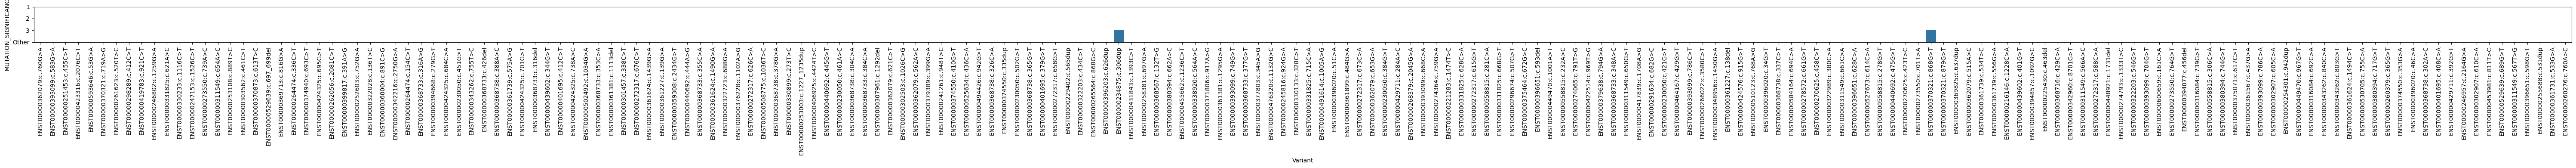

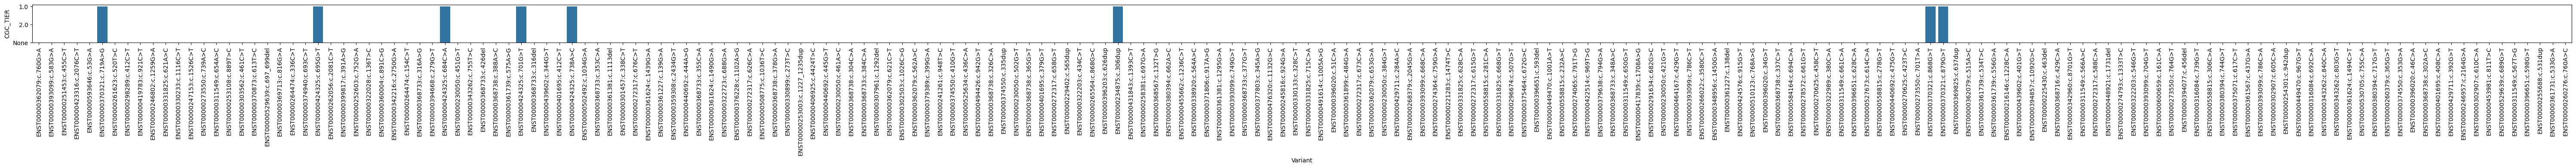

In [14]:
def make_tier_order(df, column, default_value="Other"):
    # Step 1: Extract unique tier values
    tiers = pd.Series(df[column].astype(str).fillna(default_value).unique())

    # Step 2: Split into word-like and numeric-like
    def is_numeric_like(s):
        return bool(re.fullmatch(r"\d+", s))

    word_like = sorted([t for t in tiers if not is_numeric_like(t)])
    numeric_like = sorted([t for t in tiers if is_numeric_like(t)], key=lambda x: -int(x))

    # Step 3: Concatenate final tier order
    tier_order = word_like + numeric_like
    return tier_order


# Clean and normalize the tier column
def plot_cosmic_bar_plot(df, column="MUTATION_SIGNIFICANCE_TIER", tier_order=None, default_value="Other", variant_id_column="vcrs_id"):
    df = df.copy()
    
    if tier_order is None:
        tier_order = make_tier_order(df, column, default_value)
    tier_map = {tier: i for i, tier in enumerate(tier_order)}
    tier_order_without_default = [t for t in tier_order if t != default_value]

    # Prepare plot data
    df[column] = df[column].fillna(default_value)
    df.loc[~df[column].isin(tier_order_without_default), column] = default_value

    vcrs_ids_in_order = df[variant_id_column]
    plot_df = df[[variant_id_column, column]].drop_duplicates()
    plot_df[variant_id_column] = pd.Categorical(plot_df[variant_id_column], categories=vcrs_ids_in_order, ordered=True)
    plot_df['tier_numeric'] = plot_df[column].map(tier_map)

    # Sort vcrs_ids by tier value if desired
    plot_df = plot_df.sort_values('tier_numeric')

    # Plot
    plt.figure(figsize=(max(6, len(plot_df) * 0.3), 4))
    bars = sns.barplot(
        data=plot_df,
        x=variant_id_column,
        y='tier_numeric',
    )

    plt.xticks(rotation=90)
    plt.yticks(ticks=sorted(list(tier_map.values())), labels=tier_order)
    plt.ylabel(column)
    plt.xlabel("Variant")

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cosmic_{column}_barplot.pdf"), bbox_inches="tight")
    plt.show()

plot_cosmic_bar_plot(adata.var, column="MUTATION_SIGNIFICANCE_TIER", tier_order=['Other', '3', '2', '1'], default_value="Other")
plot_cosmic_bar_plot(adata.var, column="CGC_TIER", tier_order=['None', 2., 1.], default_value="None", variant_id_column=variant_id_column)

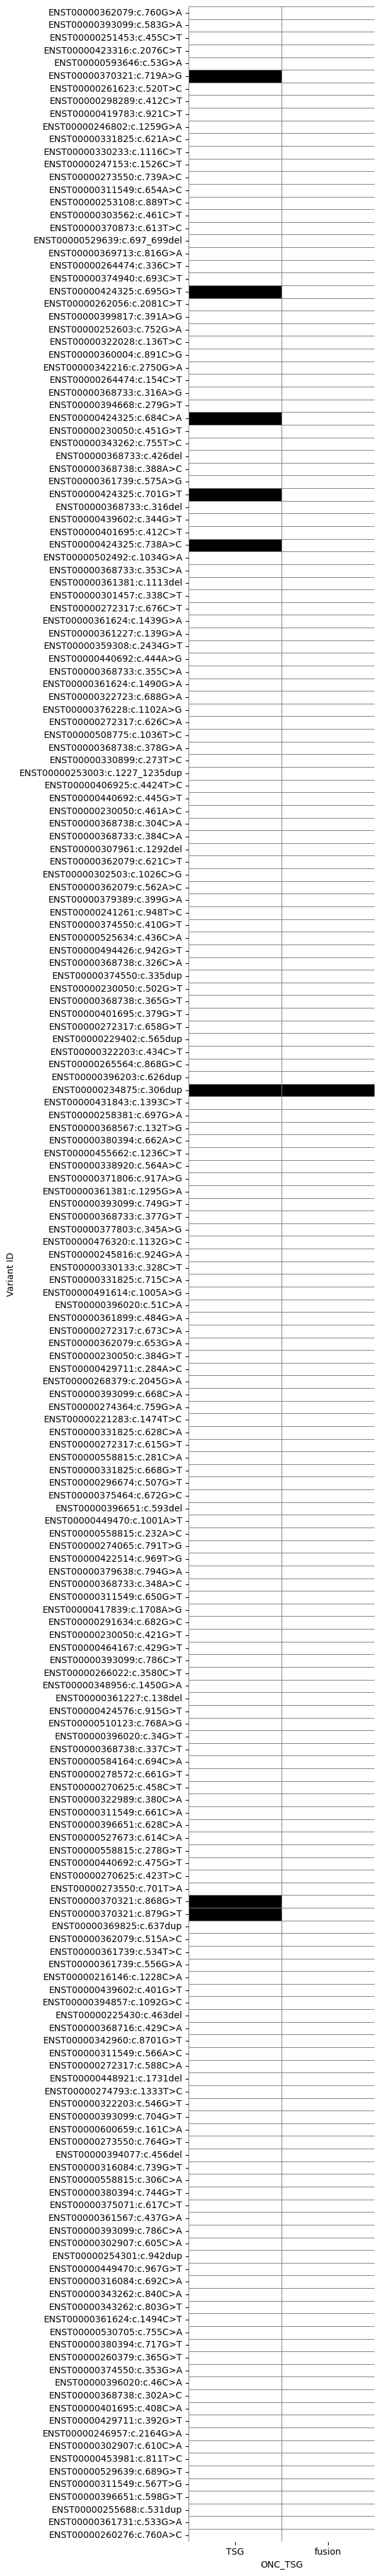

In [15]:
def plot_binary_heatmap(df, column="ONC_TSG", variant_id_column="vcrs_id"):
    df = df.copy()

    # Step 1: Copy all variant IDs for full row index
    all_variants = df[variant_id_column].astype(str)

    # Step 2: Explode column by ', '
    df = df[[variant_id_column, column]].copy()
    df[variant_id_column] = df[variant_id_column].astype(str)
    df[column] = df[column].dropna().str.split(', ')
    df = df.explode(column).dropna()

    # Step 3: Create binary matrix (variant_id x column term)
    heatmap_df = pd.crosstab(df[variant_id_column], df[column])
    heatmap_df = heatmap_df.reindex(index=all_variants, fill_value=0)  # Reindex to ensure all variants are included (fill missing with 0)

    # Step 4: Plot black-white heatmap
    plt.figure(figsize=(max(6, len(heatmap_df.columns) * 0.4), max(6, len(heatmap_df) * 0.2)))
    sns.heatmap(
        heatmap_df,
        cmap=['white', 'black'],
        linewidths=0.5,
        linecolor='gray',
        cbar=False
    )

    plt.xlabel(column)
    plt.ylabel("Variant ID")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cosmic_{column}_heatmap.pdf"), bbox_inches="tight")
    plt.show()

plot_binary_heatmap(adata.var, column="ONC_TSG", variant_id_column=variant_id_column)

In [17]:
#!!!! plot histogram of number of oncogenes and TSGs

'/Users/joeyrich/Desktop/local/RLSRWP_2025/data/vk_count_out/analysis/cosmic_lookup'

In [ ]:
#!!! annotate cell types and look at mutations across cell types